In [1]:
import qutip.core.gates
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [3]:
# Define basic operators
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

def print_gadget(gadget):
    # Build and print the tensor representation
    tensor_representation = []
    for op in gadget:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        # Check for 0.5(I - Z)
        elif (
            isinstance(op, Qobj)  # Ensure it's a Qobj
            and op.dims == I.dims  # Match single-qubit operator dimensions
            and np.allclose(op.full(), (0.5 * I - 0.5 * Z).full())  # Compare matrices
        ):
            tensor_representation.append("1/2(I-Z)")
        # Fallback for unknown operators
        else:
            tensor_representation.append("Unknown")
    
    print(f"tensor({', '.join(tensor_representation)})")
    
    
def tensor_to_str(operator):
    # Build and print the tensor representation
    tensor_representation = []
    for op in operator:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        else:
            tensor_representation.append("Unknown")
    
    return f"{''.join(tensor_representation)}"

In [4]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [5]:
def prep_aux_gad_jordan(k, i, current_position, tot_space):
    # Construct the ancillary Hamiltonian
    anc_accum = 0
    for j in range(i + 1, k):
        # Construct the pairwise interaction term for the ancillary space
        ZZ = [(Z if idx == i or idx == j else I) for idx in range(k)]
        aux_H = 0.5*(tensor([I for _ in range(k)]) - tensor(ZZ))
        
        # Embed aux_H into the full space
        pre_space = [I for _ in range(current_position)]  # Identities before this auxiliary block
        post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block
        full_aux_H = tensor(pre_space + [aux_H] + post_space)
        
        anc_accum += full_aux_H
        ###### FOR PRINTING Aux #######
        to_p = (pre_space + ZZ + post_space)
        print_gadget(to_p)
        ###### FOR PRINTING Aux #######
        
    return anc_accum


def prep_v_gad(k, op, index, j, aux_count_v, current_position, ks):
    logical_operator = tensor(
        [op if i == j else I for i in range(total_logic_qbits)]
    )
    
    # aux = [X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)]
    aux = [X if i == aux_count_v else I for i in range(k)]
    auxiliary_operator = tensor(aux)
    
    # Embed auxiliary operator into the full auxiliary space
    pre_aux = [I for _ in range(current_position - total_logic_qbits)]  # Identities for earlier stabilizers
    post_aux = [I for _ in range(sum(ks[index + 1:]))]  # Identities for remaining stabilizers
    full_auxiliary_operator = tensor(pre_aux + [auxiliary_operator] + post_aux)
    
    # Combine logical and full auxiliary operators
    full_v = tensor(logical_operator, full_auxiliary_operator)            

    ####### FOR PRINTING V #######
    # to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + [X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)] + post_aux
    to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + aux + post_aux
    print_gadget(to_p)
    ####### FOR PRINTING V #######
    
    return full_v


def gen_H_eff(H_gad, tot_q, k, X_s_k, VLambda):    
    P_plus = 0.5*(tensor([I for _ in range(tot_q)]) + X_s_k)
    
    start_time = time.time()  # Start the timer
    H_plus = P_plus * H_gad * P_plus
    end_time = time.time()  # End the timer
    
    runtime = end_time - start_time # Print the total runtime
    print(f"Eigenstate calculation completed in {runtime:.2f} seconds.")
        
    eigs_p, vecs_p = H_plus.eigenstates()
    vecs_low = [] 
    P0 = 0
    for e, v in zip(eigs_p, vecs_p):
        en = int(np.round(e, 2))
        if en == 0:
            vecs_low.append(v)
            P0 += v*v.dag()
    
    print(f"there are d = {len(vecs_low)} low eigenstates")
    A = P0 * VLambda * P0
    
    Heff = P0 * A * P0
    
    fact = math.factorial(k-1) / (-k*(-perturbation_factor)**k)
    fact = fact / k
    
    return fact * Heff
    

def prep_gadget(perturbation_factor, hs, total_logic_qbits):
    ks = [sum(1 for op in operator if op != I) for operator in hs]  # Auxiliary qubits for each stabilizer
    tot_space = total_logic_qbits + sum(ks)
    
    # Initialize the total Hamiltonian
    H_gad = 0
    VLambda = 0
    Heff = 0
    
    # Build auxiliary Hamiltonians and embed them
    current_position = total_logic_qbits  # Start after logical qubits
    before_count = 0
    total_qubits = sum(ks)

    for index, operator in enumerate(hs):
        H_gad_h = 0
        VLambda_h = 0
        
        print("Building gadget for operator", tensor_to_str(operator))
        k = sum(1 for op in operator if op != I)    
        
        for j in range(k):
            full_aux_H = prep_aux_gad_jordan(k, j, current_position, tot_space)

            H_gad += full_aux_H
            H_gad_h += full_aux_H
            
        # Now adding the perturbative terms
        aux_count_v = 0
        for j, op in enumerate(operator):
            if op == I:
                continue     
            
            full_v = prep_v_gad(k, op, index, j, aux_count_v, current_position, ks)
            aux_count_v += 1
            
            H_gad += perturbation_factor*full_v
            H_gad_h += perturbation_factor*full_v
            
            VLambda += perturbation_factor*full_v
            VLambda_h += perturbation_factor*full_v
        
        
        X_k = [X] * k
        I_before = [I] * before_count
        I_after = [I] * (total_qubits - before_count - k)
    
        X_s_k = [I] * total_logic_qbits + I_before + X_k + I_after
        print(tensor_to_str(X_s_k))
        
        # for each element in H_comp generating the Heff and summing
        Heff += gen_H_eff(H_gad_h, tot_space, k, tensor(X_s_k), VLambda_h)
        
        before_count += k
        current_position += k
    
    print("Total Hamiltonian Dimensions:", H_gad.dims)
    
    
    return tot_space, H_gad, ks, VLambda, Heff

In [6]:
h1 = [X, X, X, X]
h2 = [Z, Z, Z, Z]
h3 = [X, Y, Z, I]

h4 = [X, X, I, I]
h5 = [X, X, X, I]
hs = [h4, h5]

# Parameters
total_logic_qbits = 4  # Number of logical qubits
perturbation_factor = 0.05

tot_space, H_gad, ks, VLambda, Heff = prep_gadget(perturbation_factor, hs, total_logic_qbits)

Building gadget for operator XXII
tensor(I, I, I, I, Z, Z, I, I, I)
tensor(X, I, I, I, X, I, I, I, I)
tensor(I, X, I, I, I, X, I, I, I)
IIIIXXIII
Eigenstate calculation completed in 0.00 seconds.
there are d = 384 low eigenstates
Building gadget for operator XXXI
tensor(I, I, I, I, I, I, Z, Z, I)
tensor(I, I, I, I, I, I, Z, I, Z)
tensor(I, I, I, I, I, I, I, Z, Z)
tensor(X, I, I, I, I, I, X, I, I)
tensor(I, X, I, I, I, I, I, X, I)
tensor(I, I, X, I, I, I, I, I, X)
IIIIIIXXX
Eigenstate calculation completed in 0.00 seconds.
there are d = 320 low eigenstates
Total Hamiltonian Dimensions: [[2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2]]


Substetuting the subspace of $H_{gad}^{+}$ into the +1 of $X^{\otimes k}$ on the specific register

[2, 3]
|ψ⟩ = 0.50|000000000⟩ + 0.50|000000111⟩ + 0.50|000011000⟩ + 0.50|000011111⟩
-199.99999999999997


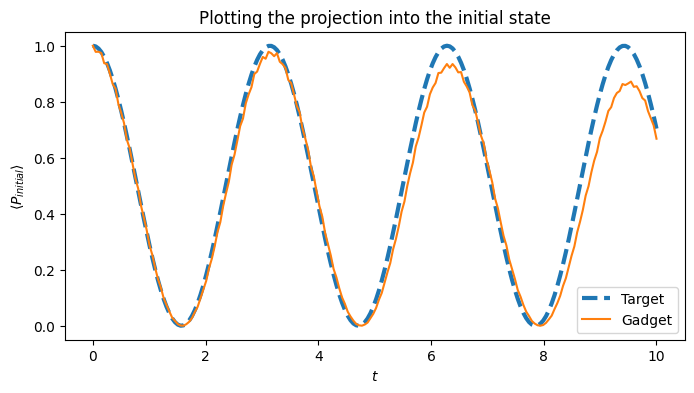

In [7]:
hadamard = qutip.core.gates.hadamard_transform(1)

zero_state_target = tensor([basis(2, 0) for _ in range(total_logic_qbits)])
initial_gad = zero_state_target
print(ks)
for k in ks:
    plus_state_anc = (tensor([basis(2, 0) for _ in range(k)]) + 
                      tensor([basis(2, 1) for _ in range(k)])).unit()

    initial_gad = tensor(initial_gad, plus_state_anc)


k = sum([1 for i in hs[0] if i != I])

print_quantum_state_as_superposition(initial_gad)
initial_target = zero_state_target

# plus_state = tensor([hadamard*basis(2,0) for _ in range(k)])
# initial_gad = tensor(initial_target, plus_state)



times = np.linspace(0, 10, 200)

krylov_dim = 6

fact = math.factorial(k-1) / (-k*(-perturbation_factor)**k)
print(fact)


# H = Heff
H = H_gad * fact

evolution_gad = sesolve(H, initial_gad, times, e_ops=[initial_gad*initial_gad.dag()], options={'nsteps': 10000})
# evolution_krylov = krylovsolve(H, initial_gad, times, e_ops=[initial_gad*initial_gad.dag()], krylov_dim=krylov_dim)
evolution = sesolve(tensor(hs[0]), initial_target, times, e_ops=[initial_target*initial_target.dag()])

plt.figure(figsize=(8,4))
plt.plot(times, evolution.expect[0], '--', label=r"Target", linewidth=3)
plt.plot(times, evolution_gad.expect[0], label=r"Gadget")
# plt.plot(times, evolution_krylov.expect[0], '--', label=r"Krylov")
plt.ylabel(r"$\langle P_{initial} \rangle$")
plt.xlabel(r"$t$")
plt.title(r"Plotting the projection into the initial state")
plt.legend()
plt.show()

In [ ]:
X_L = tensor(Y, I, Y, I)
Z_L = tensor(Z, Z, I, I)
Y_L = -tensor(I, X, X, I)

# Define logical states |0_L> and |1_L>
basis_states = [basis(2, 0), basis(2, 1)]

# Define the 4-qubit logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                   1j * tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1]) +
                   1j * tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0]) +
                   tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1])).unit()

# RAP time-dependent terms
T = 10
t = np.linspace(0, T, 200)
sigma = 1
omega_max = 10

# Modified H_S_0 with gadgets
Ep = 50
H_p = -Ep*H_gad*fact

# Expanding the space of the one local operations of the RAP to the new space
X_L_all = tensor(X_L, tensor([I for _ in range(sum(ks))]))
Z_L_all = tensor(Z_L, tensor([I for _ in range(sum(ks))]))


initial_state = logical_zero
for k in ks:
    plus_state_anc = (tensor([basis(2, 0) for _ in range(k)]) + 
                      tensor([basis(2, 1) for _ in range(k)])).unit()
    initial_state = tensor(initial_state, plus_state_anc)

    
logical_one = X_L_all * initial_state

    
# Define time-dependent Hamiltonian
def H_RAP(t, args):
    omega_t = args['omega_max'] * np.exp(-0.5 * ((t - args['T'] / 2) / args['sigma']) ** 2)
    delta_t = 2 * args['omega_max'] * (t / (args['T'] / 2) - 1)
    return omega_t * X_L_all + delta_t * Z_L_all + H_p


P_init = initial_state * initial_state.dag()
P_one = logical_one * logical_one.dag()


# Solve the system with sesolve
args = {'omega_max': omega_max, 'T': T, 'sigma': sigma}
H_td = QobjEvo(H_RAP, args=args)

result = sesolve(H_td, initial_state, t, e_ops=[P_init, P_one], options={'nsteps': 1e5})
# options={'nsteps': 1e5, 'atol': 1e-2}

# Extract probabilities
p_zero = result.expect[0]
p_one = result.expect[1]

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t, p_zero, label=r'$| \langle 0_{L} | \psi(t) \rangle |^2$', color='blue')
# plt.plot(t, p_one, label=r'$| \langle 1_{L} | \psi(t) \rangle |^2$', color='red')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Adiabatic Evolution of Logical States')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [342]:
H = Heff

eig, vec = H.eigenstates()
energies_eff = {} 
for e, v in zip(eig, vec):
    en = int(np.round(e, 2))
    if en in energies_eff.keys():
        energies_eff[en] += 1
    else:
        energies_eff[en] = 1
print("H_eff", energies_eff)

eig, vec = tensor(h1).eigenstates()
energies_eff = {} 
for e, v in zip(eig, vec):
    en = int(np.round(e, 2))
    if en in energies_eff.keys():
        energies_eff[en] += 1
    else:
        energies_eff[en] = 1
        
print("H_comp", energies_eff)

H_eff {-50: 4, -25: 40, -24: 8, 0: 152, 25: 48, 50: 4}
H_comp {-1: 8, 1: 8}
